In [54]:
import pip
pip.main(['install', '-U', 'pycse==1.6.3'])

  Running setup.py bdist_wheel for pycse: started
  Running setup.py bdist_wheel for pycse: finished with status 'done'
  Stored in directory: /home/jovyan/.cache/pip/wheels/5e/40/ff/05bee74dc41de68902582fe68c6c4b100fca353edeafec15f9
  Running setup.py bdist_wheel for quantities: started
  Running setup.py bdist_wheel for quantities: finished with status 'done'
  Stored in directory: /home/jovyan/.cache/pip/wheels/fc/e9/14/3d025a5882093ba31c3b9373fd1451c4a32f32a291b2e22899
Successfully built pycse quantities
  Found existing installation: quantities 0.11.1+36.gacba339
    Uninstalling quantities-0.11.1+36.gacba339:
      Successfully uninstalled quantities-0.11.1+36.gacba339
  Found existing installation: pycse 2.0
    Uninstalling pycse-2.0:
      Successfully uninstalled pycse-2.0


0


# Simple mole balances




## Review of the mole balance



-   **Mole** balances are performed for a *species* in a control volume

![img](./images/mole-balance.png)

\begin{align}
Accumulation &=& In - Out + Generation \\
\frac{dN_J}{dt} &=& F_{J0} - F_J + V r_J
\end{align}

-   Here we use the convention that $N_j$ refers to the total number of moles of species $J$ in the volume, $F_J$ is a molar flow of $J$, and $r_J$ is the intensive rate of production of $J$, and it has a negative magnitude if species $J$ is in fact being consumed.

Now, we consider specific examples. We will go in order of mathematical difficulty:

-   steady state, (non)linear algebraic
-   ordinary differential equations




## A continuously stirred tank reactor



Here is the typical schematic diagram of a continuously stirred tank reactor (CSTR).

![img](./images/constant-volume-cstr.png)

-   We assume the tank is well-mixed because it is well-stirred
-   The concentration at the exit is the same as everywhere in the tank
-   The mole balance at steady state ($\frac {dN_A}{dt} = 0) $ is:

$0 = F_{A0} - F_A + V r_A $




## A continuously stirred tank reactor problem



-   We have a 10L stirred tank reactor
-   $A$ flows in at a molar flow rate of 1 mol/hr and volumetric flowrate of 2.5 L/hr
-   $-r_A = k C_A$, $k = 0.23$ 1/hr
-   What is the steady-state exit concentration of $A$?

-   The equations

\begin{align}
\frac{dN_A}{dt} = 0 &=& F_{A0} - F_A + V r_A \\
                  0 &=& F_{A0} - F_A  - V k C_{A, exit} \\
                  0 &=& F_{A0} - v_0 C_{A, exit} - V  k C_{A, exit}
\end{align}

\begin{align}
C_{A, exit} = \frac{F_{A0}}{v_0 + V k}
\end{align}

-   Only for constant volume
-   Assumes well-mixed, i.e. uniform concentration




## Solving the problem with algebra (CSTR)



-   Simple algebra



In [18]:
k = 0.23  # 1/hr
Fa0 = 1.0 # mol /hr
v0 = 2.5  # L /hr
V = 10    # L

Ca_exit = Fa0 / (v0 + V * k)
print('Ca_exit = {0:1.3f} mol / L'.format(Ca_exit))

Ca_exit = 0.208 mol / L


-   This was an easy problem, but the algebraic manipulations are all possible places where errors can be made.
-   Let us consider a numerical approach




## Solving the problem numerically using a solver (CSTR)



-   We have to create a function that is equal to zero at the solution.
    -   We have that directly from the mole balance:
        
        $0 = F_{A0} - F_A + V r_A$
    
    -   We just have to make sure to use the correct variables, with correct units.

-   We use a nonlinear solver, so we also have to provide an initial guess. You may want to review [scipy.optimize.fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html)



In [21]:
from scipy.optimize import fsolve

k = 0.23   # 1/hr
Fa0 = 1.0  # mol /hr
v0 = 2.5   # L /hr
V = 10     # L

def func(Ca):
    ra = -k * Ca
    Fa = v0 * Ca
    return Fa0 - Fa + V * ra

guess = 1.0  # mol / L
ans, = fsolve(func, guess)  # note the comma after ans. That "unpacks" the array

print('Ca_exit = {0} mol/L'.format(ans))

Ca_exit = 0.20833333333333334 mol/L


-   This had less manipulation, and fewer opportunities for mistakes
-   On the other hand, we ended up using a solver that required an initial guess to solve a linear problem.
-   This was a simple problem, but other problems will not be linear, and will be much more difficult.
-   Remember what the units are? Were they consistent?




## Solving the problem with uncertainty (CSTR)



[uncertainty](uncertainty)

-   Uncertainty analysis is not built in to python
-   We have to install the `uncertainties` package and import it

Let us assume there is some uncertainty in the rate constant, say it is $k = 0.23 \pm 0.1$ 1/hr.

-   Is that a lot of uncertainty?

We can use the `uncertainties` package to propagate that error automatically.

[uncertainties.ufloat](https://www.google.com/#safe=off&q=uncertainties.ufloat)



In [53]:
import uncertainties as u

k = u.ufloat(0.23, 0.1)   # rate constant 1/hr
Fa0 = 1.0                 # inlet molar flow mol/hr
v0 = u.ufloat(2.5,1)                  # volumetric flow L/hr
V = 10                    # reactor volume L
Cae = Fa0 / (v0 + V * k)
print('Ca,exit = {0}'.format(Cae))

Ca,exit = 0.21+/-0.06


-   `uncertainties` is also great for simple problems
-   We have to do some work to make it work in other situations




# Mole balance on a batch reactor



The next more complex (mathematically) mole balance is the batch reactor. The batch reactor does not operate at steady state, and therefore we have an ordinary differential equation that describes the number of moles in the reactor as a function of time.

![img](./images/constant-volume-batch.png)

-   Constant volume
-   No flow in or out

$ \frac{dN_A}{dt} = V r_A $




## Simple application of a mole balance to a constant volume batch reactor



-   At $t=0$ we have an initial concentration of 2 mol/L
-   $-r_A = k C_A$ with $k = 0.23$ 1/hr
-   How much A is left after 1 hour?

-   Equations

\begin{align}
N_A &=& C_A V \\
\frac{dN_A}{dt} &=& V \frac{dC_A}{dt} \\
\frac{dC_A}{dt} &=& r_A = -k C_A \\
C_A(t=0) &=& C_{A0}
\end{align}

-   Only for constant volume
-   Assumes well-mixed, i.e. uniform concentration
-   Initial condition, ordinary differential equation




## Solving the problem (constant volume batch reactor)



We have an ordinary differential equation with an initial condition. We need to integrate it from t=0 to t=1 hour, and then get the solution at t=1 hour.

[scipy.integrate.odeint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)



In [26]:
import numpy as np
from scipy.integrate import odeint

k = 0.23   # 1/hr
Ca0 = 2.0  # mol / L

def ode(Ca, t):
    dCadt = -k * Ca
    return dCadt

tspan = np.linspace(0, 1)  # hours
sol = odeint(ode, Ca0,  tspan)

# sol is a 2d array. It has as many rows as tspan, and as many columns as Ca0
print(type(sol), sol.shape)

# We want the last value of sol, which is in the last row, column 0
print('C_A at t = 1 hour = {0} mol/L'.format(sol[-1, 0]))

<class 'numpy.ndarray'> (50, 1)
C_A at t = 1 hour = 1.589067228361415 mol/L


In [28]:
sol[-1,0]

1.5890672283614149

-   Remember what the units are?




## Plotting $C_A$ vs. time in a batch reactor



-   Now let us solve the ODE and plot the solution.



shapes:  (3,) (3, 1)
[[file:pyshow/a4c5fbd35dec41bb5ed165d7f1d228450936e643.png]]


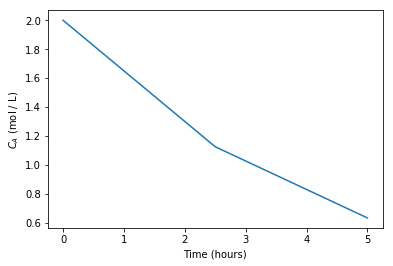

In [37]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

k = 0.23   # 1 / hr
Ca0 = 2.0  # mol / L

def ode(Ca, t):
    dCadt = -k * Ca
    return dCadt

tspan = np.linspace(0, 5,3)
sol = odeint(ode, Ca0,  tspan)

# Note: tspan is a 1d array, and sol is a 2d array. numpy understands these
# arrays are compatible based on their sizes and shapes.
print('shapes: ',tspan.shape, sol.shape)

plt.plot(tspan, sol)
plt.xlabel('Time (hours)')
plt.ylabel('$C_A$ (mol / L)')
plt.show()

-   $C_A$ decreases with time (it is consumed)
-   It is not apparent from this graph because of the short time, but the concentration decreases exponentially with time (plot for longer time to see it).




# Mole balance in a plug flow reactor



-   In the plug flow reactor, reactants enter the front of the reactor and disappear as they flow through the reactor

![img](./images/pfr-schematic.png)

-   We assume our differential element is well-mixed
-   The mole balance on the differential element leads to

$ \frac{dN_A}{dt} = F_A |_V - F_A |_{V + \Delta V} + \Delta V r_A $

-   At steady state, in the limit of $\Delta V \rightarrow 0$ we get:

$ \frac{dF_A}{dV} = r_A $

-   This is an ordinary differential equation (but it varies in space, not time), and to solve it we need an initial condition on the molar flow at $V=0$.




## A worked PFR example



-   Given a 100 L reactor with $A$ flowing in at a concentration of 3 mol/L and a rate of 10 L/min
-   The reaction $A \rightarrow B$ occurs at a rate law of $r = k C_A$ with $k = 0.23$ 1/min
-   What is the exit concentration of $A$?

-   We have $\frac{dF_A}{dV} = r_A $
-   We have $r_A = -r$ (stoichiometry)
-   $F_A(V=0) = C_{A0} v_0$



In [38]:
from scipy.integrate import odeint

Ca0 = 3.0  # mol / L
v0 = 10.0  # volumetric flowrate L/min
k = 0.23   # rate constant 1/min

def ode(Fa, V):
    Ca = Fa / v0
    return -k * Ca

Vspan = [0, 100] # reactor volume

sol = odeint(ode, Ca0 * v0, Vspan)
Fa_exit = sol[-1, 0] # last row, column 0

print('Exit concentration = {0:1.4f} mol/L'.format(Fa_exit / v0))

Exit concentration = 0.3008 mol/L


In [39]:
sol

array([[ 30.       ],
       [  3.0077653]])

-   Our solution only has two points in it: 0 and 100L
    -   We cannot visualize the concentration profile




## A harder PFR example



-   The reaction $A \rightarrow B$ occurs at a rate law of $r = k C_A$ with $k = 0.23$ 1/min
-   If  $A$ is flowing in at a concentration of 3 mol/L and a rate of 10 L/min
-   How large should the reactor be to reduce the concentration of $A$ to 0.3 mol/L?

There are many ways to approach this.

-   You could integrate $\frac{dF_A}{dV} = r_A$ and graphically determine where the solution is.
-   You could setup a numerical approach to solving the equation

-   First we graph the solution. the code is almost the same as before, but we integrate over more points and a larger range to get a smooth curve.



[[file:pyshow/4647e6ef89989289dd86a0306fbfc372975d3485.png]]


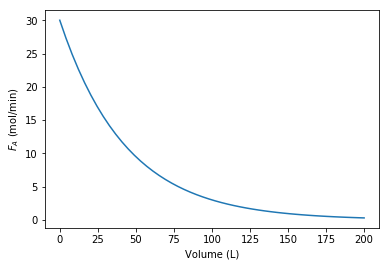

In [44]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Ca0 = 3.0 # mol / L
v0 = 10.0 # L / min
k = 0.23  # 1/min

def ode(Fa, V):
    Ca = Fa / v0
    return -k * Ca

Vspan = np.linspace(0, 200) # volumes to integrate over

sol = odeint(ode, Ca0 * v0, Vspan)

plt.plot(Vspan, sol)
plt.xlabel('Volume (L)')
plt.ylabel('$F_A$ (mol/min)')
plt.show()

-   at $C_A = 0.3$ mol/L, $F_A = 3$ mol/min.
-   We know the answer from before: It is about 100 L.
-   It is hard to be very accurate this way, although interactive graphics help



## Numerical solution



-   To numerically solve this we must solve a function $f(V) = 0$.
-   Here is one approach
-   Starting from $\frac{dF_A}{dV} = -k F_A/\nu$ we derive:

\begin{align}
f(V) = \int_{F_{A0}}^{F_A} \frac{dF_A}{F_A} - \int_{V=0}^{V} \frac{-k}{\nu}dV
\end{align}

where everything is known but $V$. We use numerical quadrature to evaluate the integrals.

[scipy.integrate.quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html)



In [43]:
from scipy.integrate import quad
from scipy.optimize import fsolve

k = 0.23        # 1/min
nu = 10         # L/min
Ca0 = 3.0       # mol / L
Fa0 = Ca0 * nu
Fa = 0.30 * nu

def integrand1(Fa):
    return 1.0 / Fa

def integrand2(V):
    return -k / nu

def func(V):
    I1, e1 = quad(integrand1, Fa0, Fa)
    I2, e2 = quad(integrand2, 0, V)
    return I1 - I2

guess = 120 # Liters
sol = fsolve(func, guess)
print('Volume = {0:1.2f}'.format(float(sol)))

Volume = 100.11


-   This also leaves something to be desired in complexity
-   Many opportunities for mistakes in the derivation
-   Requires sophisticated thinking about the problem
-   Other approaches require similar or more sophistication!




## Using events to stop integration



-   An alternative to the methods above is to use an ODE solver that is aware of events to stop the integration where you want it.

-   `pycse` provides a function like this called `odelay`. [pycse.odelay](https://www.google.com/#safe=off&q=pycse.odelay)

-   You define an event function that equals zero at the event. You specify if the event is terminal, and whether to the zero must be approached from above or below, or if all zeros count.

-   Here is an example.



Solution is at 100.11242229762259 L
[[file:pyshow/ff9e13141cf4e47830a702f56c85170be6fb90d0.png]]


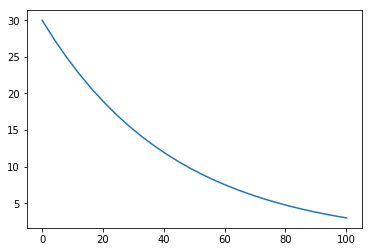

In [49]:
import numpy as np
from pycse import odelay

Ca0 = 3.0  # mol / L
v0 = 10.0  # L / min
k = 0.23   # 1 / min

Fa_Exit = 0.3 * v0

def ode(Fa, V):
    Ca = Fa / v0
    return -k * Ca

def event1(Fa, V):
    isterminal = True
    direction = 0
    value = Fa - Fa_Exit
    return value, isterminal, direction

Vspan = np.linspace(0, 200) # L

V, F, TE, YE, IE = odelay(ode, Ca0 * v0, Vspan, events=[event1])

print('Solution is at {0} L'.format(V[-1]))
import matplotlib.pyplot as plt

plt.plot(V, F)

plt.show()

-   As you can see, there are many ways to solve this problem
-   It is *not* necessary to know every single way to do it, but knowing multiple ways increases your ability to solve other problems in the future
-   And provides ways to check your solution by other methods.




## Solution by interpolation



-   Solve the problem on a grid
-   Create interpolation function for the solution to approximate solutions between grid points.  [scipy.interpolate.interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)
-   Use fsolve to find the solution



In [50]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d

Ca0 = 3.0  # mol / L
v0 = 10.0  # L / min
k = 0.23   # 1 / min

def ode(Fa, V):
    'dFa/dV = ra'
    Ca = Fa / v0
    r = k * Ca
    ra = -r
    return ra

Vspan = np.linspace(0, 200,5) # L

sol = odeint(ode, Ca0 * v0, Vspan)

Ca_exit = 0.3 # mol / L
Fa_exit = Ca_exit * v0

# Note that here we cannot mix 1d and 2d arrays. We must extract a 1d
# array from the solution. We do that with sol[:, 0] which means take
# all rows in column 0.
interp_func = interp1d(Vspan, sol[:, 0], 'cubic')

def objective(V):
    'equal to zero when F(V) = Fa_exit'
    return interp_func(V) - Fa_exit

from scipy.optimize import fsolve
V_sol = fsolve(objective, 100)
print('Solution is at {0} L'.format(float(V_sol)))

Solution is at 100.12059485096383 L


-   Note that you may be limited by the accuracy of your interpolation here. Solving the ODE with a fine mesh of points will increase the accuracy of the solution. Or using more accurate interpolations, e.g. splines, can also increase the accuracy.



In [52]:
print(interp_func)